# Laboratorio 2 - Data Science

In [213]:
!pip install --upgrade pip
!pip install --upgrade numpy tensorflow
!pip install numpy==1.23.5

  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
graphdatascience 1.13 requires numpy<2.0, but you have numpy 2.1.3 which is incompatible.
graphdatascience 1.13 requires pyarrow<19.0,>=15.0.2, but you have pyarrow 21.0.0 which is incompatible.
graphdatascience 1.13 requires tenacity>=9.0, but you have tenacity 8.5.0 which is incompatible.
langchain 0.3.7 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
langchain 0.3.7 requires pydantic<3.0.0,>=2.7.4, but you have pydantic 2.5.2 which is incompatible.
langchain-community 0.3.7 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
langchain-pinecone 0.2.0 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
streamlit 1.34.0 requires numpy<2,>=1.19.3, but you have numpy 2.1.3 which is inc

  Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
graphdatascience 1.13 requires pyarrow<19.0,>=15.0.2, but you have pyarrow 21.0.0 which is incompatible.
graphdatascience 1.13 requires tenacity>=9.0, but you have tenacity 8.5.0 which is incompatible.
langchain 0.3.7 requires pydantic<3.0.0,>=2.7.4, but you have pydantic 2.5.2 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
streamlit 1.34.0 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.3 which is incompatible.


In [214]:
import numpy as np
import tensorflow as tf

(X_entreno, y_entreno), (X_prueba, y_prueba) = tf.keras.datasets.mnist.load_data()
X_entreno.shape

(60000, 28, 28)

In [215]:
assert X_entreno.shape == (60000, 28, 28)
assert X_prueba.shape == (10000, 28, 28)
assert y_entreno.shape == (60000,)
assert y_prueba.shape == (10000,)

In [304]:
num_obs_validacion = y_prueba.shape[0]
num_obs_prueba = y_prueba.shape[0]


In [303]:
X_entreno_normalizado = X_entreno / 255
X_prueba_normalizado = X_prueba / 255

In [302]:
X_validacion = X_entreno_normalizado[-num_obs_validacion: , : , : ]
y_validacion = y_entreno[-num_obs_validacion:]

In [305]:
X_entreno = X_entreno_normalizado[ : X_entreno_normalizado.shape[0] - num_obs_validacion, : , : ]
y_entreno = y_entreno[ : y_entreno.shape[0] - num_obs_validacion]
num_obs_entreno = y_entreno.shape[0]

In [ ]:
BATCH_SIZE = 100
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

BIG_BATCH = 10000
datos_entreno_bigbatch = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(BIG_BATCH)
datos_validacion_bigbatch = datos_validacion.batch(BIG_BATCH)
datos_prueba_bigbatch = datos_prueba.batch(BIG_BATCH)

datos_entreno = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(BATCH_SIZE)
datos_validacion = datos_validacion.batch(BATCH_SIZE)
datos_prueba = datos_prueba.batch(BATCH_SIZE)

# Inicializar arrays para guardar resultados
training_times = []
test_accuracies = []
test_losses = []


## Modelo

In [221]:
# Vars constantes
from matplotlib import pyplot as plt
import time
NUM_EPOCHS = 20

class RNN():
    def __init__(
            self,
            entrada,
            salida,
            capa_escondida,
        ):
        self.entrada = entrada
        self.salida = salida
        self.capa_escondida = capa_escondida
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            
            tf.keras.layers.Dense(capa_escondida, activation='relu'), # 2nda capa escondida

            tf.keras.layers.Dense(salida, activation='softmax') # capa salida
        ])
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    def train(self, train_data, validation_data, num_epochs, verbose=0):
        start_time = time.time()
        self.history = self.model.fit(
            train_data,
            epochs = num_epochs, 
            validation_data = validation_data,
            verbose = verbose
        )
        end_time = time.time()
        train_loss = self.history.history['loss'][-1]
        train_acc = self.history.history['accuracy'][-1]
        val_loss = self.history.history['val_loss'][-1]
        val_acc = self.history.history['val_accuracy'][-1]
        t_time = end_time - start_time
        return (train_loss, train_acc, val_loss, val_acc, t_time)
    
    def test(self, test_data):
        loss, accuracy = self.model.evaluate(test_data)
        return (loss, accuracy)
    
    def plot_accuracy(self, title):
        plt.plot(self.history.history['accuracy'], label="Train")
        plt.plot(self.history.history['val_accuracy'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_loss(self, title):
        plt.plot(self.history.history['loss'], label="Train")
        plt.plot(self.history.history['val_loss'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

## 1. Modular Neuronas de capas internas

In [222]:
# iterar por cada una de las topologias
performance_1 = [] # almacenamiento de resultados

for inner_size in [50, 100, 200, 300, 500]:
    # Inicializar RNN
    m1 = RNN(784, 10, inner_size)
    # Compilar otpimizador
    m1.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Metricas de etrenamiento
    (e_loss, e_acc, _, _, t_time) = m1.train(datos_entreno, datos_validacion, num_epochs=20)
    # Metricas de prueba
    t_loss, t_acc = m1.test(datos_prueba)
    if(inner_size==200):
        training_times.append(t_time)  # Guardar tiempo
        test_losses.append(t_loss)     # Guardar pérdida
        test_accuracies.append(t_acc)  # Guardar accuracy
    performance_1.append({"Ancho": inner_size, "e_loss": e_loss, "e_acc": e_acc, "t_loss": t_loss, "t_acc": t_acc, "training_time": t_time})
    print(f"finished for inner size {inner_size}")
    

C:\Users\50250\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 22.4020
finished for inner size 50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9709 - loss: 21.8549
finished for inner size 100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9773 - loss: 21.4716
finished for inner size 200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9783 - loss: 20.1553
finished for inner size 300
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9802 - loss: 21.1988
finished for inner size 500


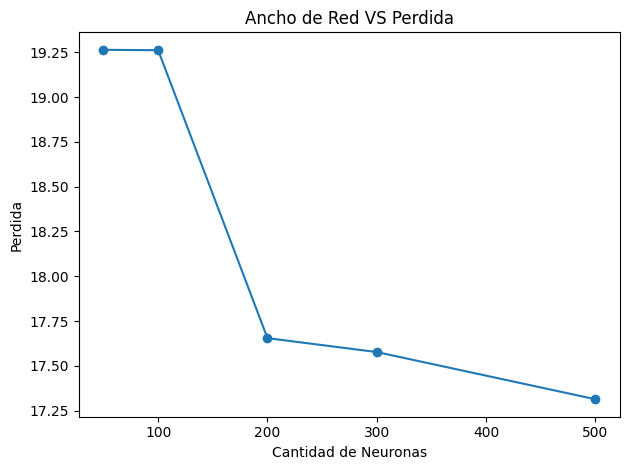

In [223]:
import pandas as pd
df1 = pd.DataFrame(performance_1)
plt.title("Ancho de Red VS Perdida")
plt.plot(df1["Ancho"], df1["t_loss"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Perdida")
plt.tight_layout()
plt.show()

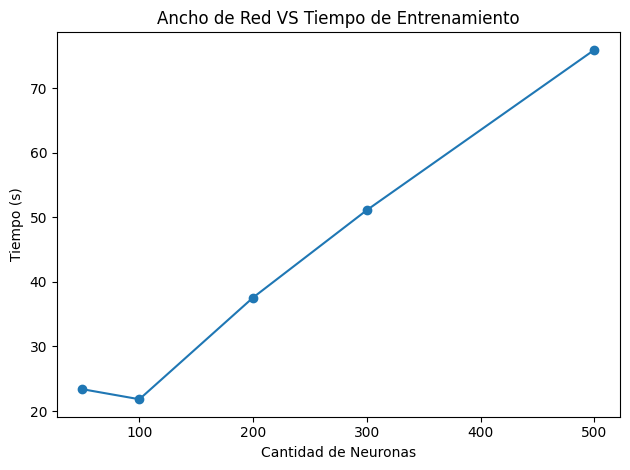

In [224]:
plt.title("Ancho de Red VS Tiempo de Entrenamiento")
plt.plot(df1["Ancho"], df1["training_time"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Tiempo (s)")
plt.tight_layout()
plt.show()

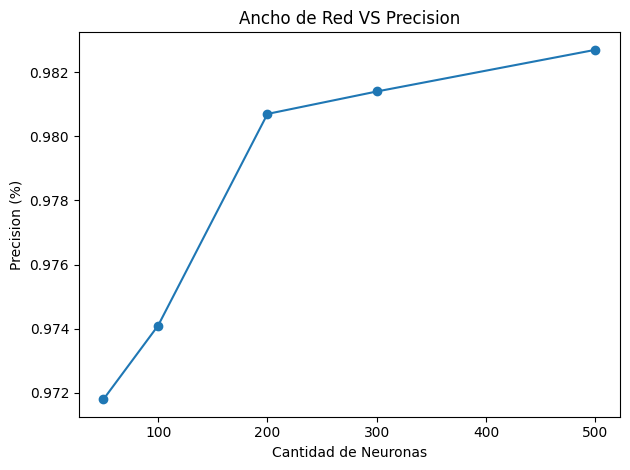

In [225]:
plt.title("Ancho de Red VS Precision")
plt.plot(df1["Ancho"], df1["t_acc"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Precision (%)")
plt.tight_layout()
plt.show()

In [226]:
df1

,Ancho,e_loss,e_acc,t_loss,t_acc,training_time
0,50,0.029978,0.99196,19.263439,0.9718,23.382028
1,100,0.009257,0.99828,19.261183,0.9741,21.828816
2,200,0.003907,0.99938,17.654598,0.9807,37.578431
3,300,0.002305,0.99956,17.577005,0.9814,51.112089
4,500,0.002685,0.99938,17.313671,0.9827,75.923109


## 2. Profundidad de Red

In [227]:
# Modelo con una capa interna
m2_one_layer = RNN(784, 10, 200)
m2_one_layer.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(200, activation='relu'), # 1a capa escondida
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m2_one_layer.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modelo con 2 capas internas
m2_two_layer = RNN(784, 10, 200)
m2_two_layer.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(200, activation='relu'), # 1a capa escondida
            tf.keras.layers.Dense(200, activation='relu'), # 2a capa escondida
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m2_two_layer.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\50250\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [228]:
for i, layer in enumerate(m2_one_layer.model.layers):
    weights = layer.get_weights() 
    print(f"Layer {i}: {layer.name}")
    for j, param in enumerate(weights):
        print(f"  Param {j} shape: {param.shape}")
m2_one_layer.model.summary()

Layer 0: flatten_189
Layer 1: dense_573
  Param 0 shape: (784, 200)
  Param 1 shape: (200,)
Layer 2: dense_574
  Param 0 shape: (200, 10)
  Param 1 shape: (10,)


Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_189 (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_573 (Dense)               │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_574 (Dense)               │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,010 (621.13 KB)

 Trainable params: 159,010 (621.13 KB)

 Non-trainable params: 0 (0.00 B)

In [229]:
for i, layer in enumerate(m2_two_layer.model.layers):
    weights = layer.get_weights()
    print(f"Layer {i}: {layer.name}")
    for j, param in enumerate(weights):
        print(f"  Param {j} shape: {param.shape}")
m2_two_layer.model.summary()

Layer 0: flatten_191
Layer 1: dense_577
  Param 0 shape: (784, 200)
  Param 1 shape: (200,)
Layer 2: dense_578
  Param 0 shape: (200, 200)
  Param 1 shape: (200,)
Layer 3: dense_579
  Param 0 shape: (200, 10)
  Param 1 shape: (10,)


Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_191 (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_577 (Dense)               │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_578 (Dense)               │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,210 (778.16 KB)

 Trainable params: 199,210 (778.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
500/500 - 4s - 8ms/step - accuracy: 0.9074 - loss: 0.3330 - val_accuracy: 0.9526 - val_loss: 0.1750
Epoch 2/20
500/500 - 3s - 6ms/step - accuracy: 0.9569 - loss: 0.1509 - val_accuracy: 0.9659 - val_loss: 0.1232
Epoch 3/20
500/500 - 3s - 6ms/step - accuracy: 0.9695 - loss: 0.1047 - val_accuracy: 0.9713 - val_loss: 0.1017
Epoch 4/20
500/500 - 3s - 6ms/step - accuracy: 0.9778 - loss: 0.0779 - val_accuracy: 0.9731 - val_loss: 0.0896
Epoch 5/20
500/500 - 3s - 6ms/step - accuracy: 0.9829 - loss: 0.0602 - val_accuracy: 0.9730 - val_loss: 0.0891
Epoch 6/20
500/500 - 3s - 5ms/step - accuracy: 0.9859 - loss: 0.0487 - val_accuracy: 0.9770 - val_loss: 0.0812
Epoch 7/20
500/500 - 3s - 6ms/step - accuracy: 0.9893 - loss: 0.0383 - val_accuracy: 0.9774 - val_loss: 0.0805
Epoch 8/20
500/500 - 3s - 5ms/step - accuracy: 0.9922 - loss: 0.0305 - val_accuracy: 0.9780 - val_loss: 0.0741
Epoch 9/20
500/500 - 3s - 6ms/step - accuracy: 0.9936 - loss: 0.0246 - val_accuracy: 0.9776 - val_loss: 0.0783
E

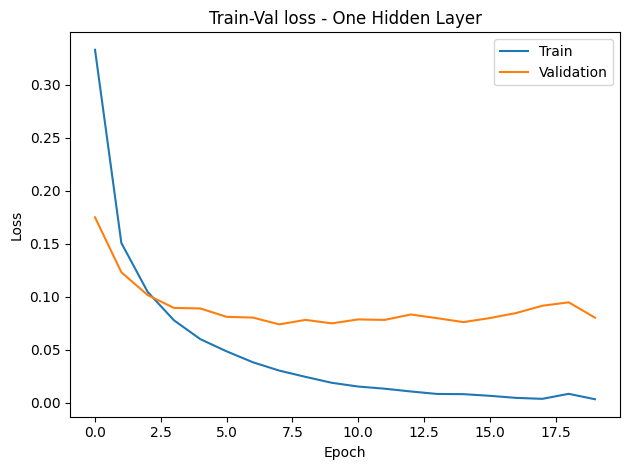

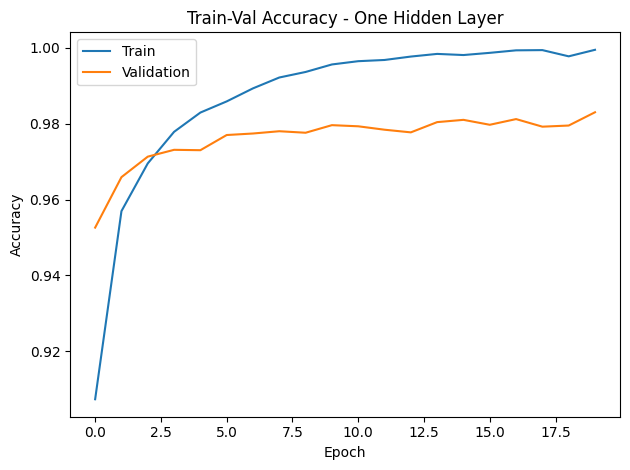

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9775 - loss: 20.2057 
Testing loss: 17.10752296447754, Testing Accuracy: 0.9803000092506409


In [230]:
# Entrenamiento 1a capa
(e_loss, e_acc, _, _, t_time) = m2_one_layer.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m2_one_layer.plot_loss("Train-Val loss - One Hidden Layer")
m2_one_layer.plot_accuracy("Train-Val Accuracy - One Hidden Layer")
t_loss, t_acc = m2_one_layer.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 4s - 8ms/step - accuracy: 0.9164 - loss: 0.2893 - val_accuracy: 0.9605 - val_loss: 0.1424
Epoch 2/20
500/500 - 3s - 5ms/step - accuracy: 0.9663 - loss: 0.1099 - val_accuracy: 0.9722 - val_loss: 0.0920
Epoch 3/20
500/500 - 3s - 6ms/step - accuracy: 0.9769 - loss: 0.0737 - val_accuracy: 0.9768 - val_loss: 0.0820
Epoch 4/20
500/500 - 3s - 6ms/step - accuracy: 0.9840 - loss: 0.0520 - val_accuracy: 0.9759 - val_loss: 0.0811
Epoch 5/20
500/500 - 3s - 6ms/step - accuracy: 0.9878 - loss: 0.0397 - val_accuracy: 0.9777 - val_loss: 0.0740
Epoch 6/20
500/500 - 3s - 6ms/step - accuracy: 0.9906 - loss: 0.0303 - val_accuracy: 0.9768 - val_loss: 0.0843
Epoch 7/20
500/500 - 3s - 6ms/step - accuracy: 0.9918 - loss: 0.0250 - val_accuracy: 0.9782 - val_loss: 0.0781
Epoch 8/20
500/500 - 3s - 5ms/step - accuracy: 0.9945 - loss: 0.0177 - val_accuracy: 0.9779 - val_loss: 0.0845
Epoch 9/20
500/500 - 3s - 5ms/step - accuracy: 0.9940 - loss: 0.0177 - val_accuracy: 0.9774 - val_loss: 0.1014
E

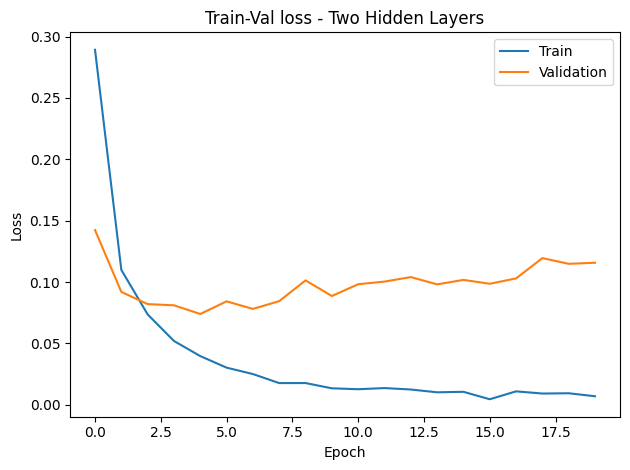

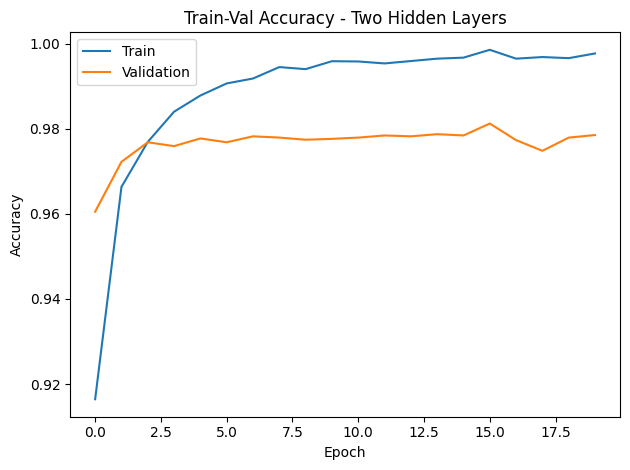

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9745 - loss: 31.7955
Testing loss: 24.912071228027344, Testing Accuracy: 0.9793000221252441


In [231]:
# Entrenamiento 2 capas
(e_loss, e_acc, _, _, t_time) = m2_two_layer.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m2_two_layer.plot_loss("Train-Val loss - Two Hidden Layers")
m2_two_layer.plot_accuracy("Train-Val Accuracy - Two Hidden Layers")
t_loss, t_acc = m2_two_layer.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

## 3. Redes profunas

Epoch 1/20
500/500 - 4s - 7ms/step - accuracy: 0.9111 - loss: 0.2913 - val_accuracy: 0.9655 - val_loss: 0.1212
Epoch 2/20
500/500 - 3s - 5ms/step - accuracy: 0.9686 - loss: 0.1025 - val_accuracy: 0.9654 - val_loss: 0.1122
Epoch 3/20
500/500 - 3s - 5ms/step - accuracy: 0.9786 - loss: 0.0683 - val_accuracy: 0.9758 - val_loss: 0.0865
Epoch 4/20
500/500 - 3s - 5ms/step - accuracy: 0.9842 - loss: 0.0509 - val_accuracy: 0.9726 - val_loss: 0.0969
Epoch 5/20
500/500 - 2s - 5ms/step - accuracy: 0.9878 - loss: 0.0397 - val_accuracy: 0.9783 - val_loss: 0.0833
Epoch 6/20
500/500 - 2s - 5ms/step - accuracy: 0.9895 - loss: 0.0318 - val_accuracy: 0.9774 - val_loss: 0.0817
Epoch 7/20
500/500 - 2s - 5ms/step - accuracy: 0.9911 - loss: 0.0274 - val_accuracy: 0.9719 - val_loss: 0.1099
Epoch 8/20
500/500 - 3s - 5ms/step - accuracy: 0.9913 - loss: 0.0277 - val_accuracy: 0.9786 - val_loss: 0.0872
Epoch 9/20
500/500 - 3s - 5ms/step - accuracy: 0.9933 - loss: 0.0217 - val_accuracy: 0.9780 - val_loss: 0.0890
E

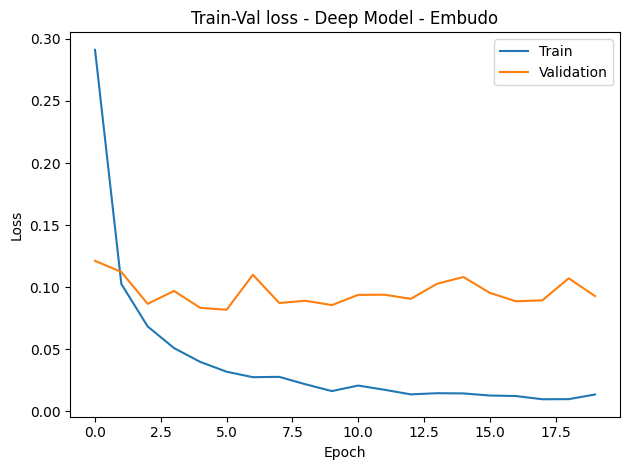

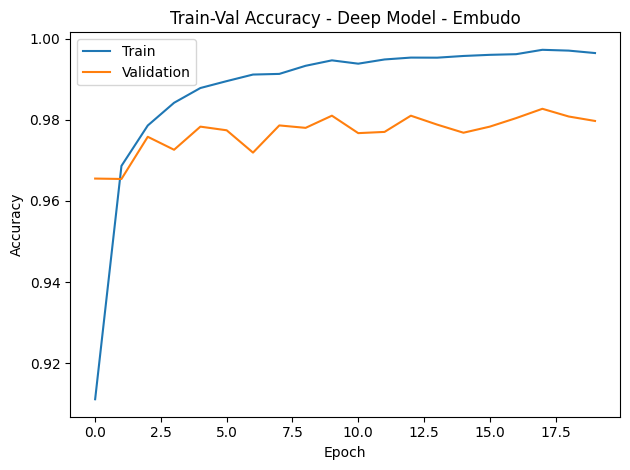

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9756 - loss: 24.4084
Testing loss: 20.707935333251953, Testing Accuracy: 0.9797000288963318


In [232]:
# Init
m3_a = RNN(784, 10, 200)
m3_a.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_a.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_a.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m3_a.plot_loss("Train-Val loss - Deep Model - Embudo")
m3_a.plot_accuracy("Train-Val Accuracy - Deep Model - Embudo")

# Test
t_loss, t_acc = m3_a.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy

print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 7s - 14ms/step - accuracy: 0.9139 - loss: 0.2831 - val_accuracy: 0.9613 - val_loss: 0.1272
Epoch 2/20
500/500 - 5s - 10ms/step - accuracy: 0.9672 - loss: 0.1094 - val_accuracy: 0.9647 - val_loss: 0.1179
Epoch 3/20
500/500 - 5s - 10ms/step - accuracy: 0.9767 - loss: 0.0769 - val_accuracy: 0.9720 - val_loss: 0.0977
Epoch 4/20
500/500 - 5s - 10ms/step - accuracy: 0.9806 - loss: 0.0625 - val_accuracy: 0.9755 - val_loss: 0.0894
Epoch 5/20
500/500 - 5s - 10ms/step - accuracy: 0.9849 - loss: 0.0484 - val_accuracy: 0.9734 - val_loss: 0.0991
Epoch 6/20
500/500 - 5s - 10ms/step - accuracy: 0.9880 - loss: 0.0396 - val_accuracy: 0.9720 - val_loss: 0.1100
Epoch 7/20
500/500 - 5s - 10ms/step - accuracy: 0.9891 - loss: 0.0353 - val_accuracy: 0.9755 - val_loss: 0.0987
Epoch 8/20
500/500 - 5s - 10ms/step - accuracy: 0.9913 - loss: 0.0287 - val_accuracy: 0.9717 - val_loss: 0.1148
Epoch 9/20
500/500 - 5s - 9ms/step - accuracy: 0.9906 - loss: 0.0302 - val_accuracy: 0.9778 - val_loss: 

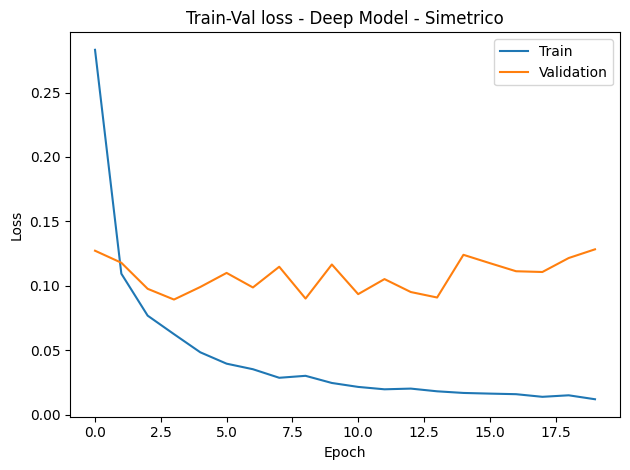

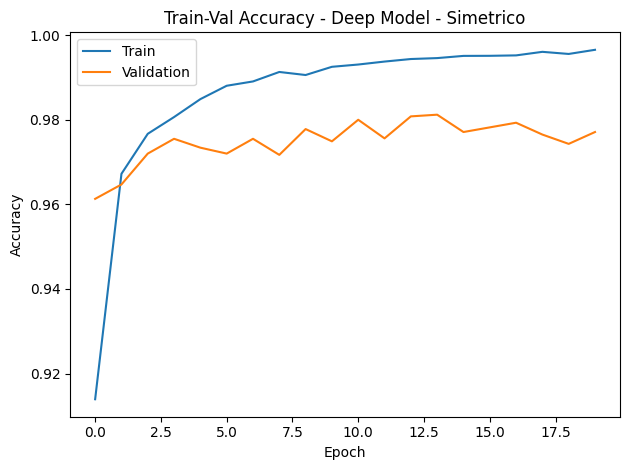

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9718 - loss: 31.0725
Testing loss: 26.191280364990234, Testing Accuracy: 0.9767000079154968


In [233]:
# Init
m3_b = RNN(784, 10, 200)
m3_b.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_b.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_b.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m3_b.plot_loss("Train-Val loss - Deep Model - Simetrico")
m3_b.plot_accuracy("Train-Val Accuracy - Deep Model - Simetrico")
training_times.append(t_time)  # Guardar tiempo
# Test
t_loss, t_acc = m3_b.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 6s - 13ms/step - accuracy: 0.9123 - loss: 0.2900 - val_accuracy: 0.9574 - val_loss: 0.1443
Epoch 2/20
500/500 - 3s - 7ms/step - accuracy: 0.9667 - loss: 0.1124 - val_accuracy: 0.9648 - val_loss: 0.1134
Epoch 3/20
500/500 - 2s - 5ms/step - accuracy: 0.9775 - loss: 0.0751 - val_accuracy: 0.9736 - val_loss: 0.0906
Epoch 4/20
500/500 - 2s - 5ms/step - accuracy: 0.9831 - loss: 0.0562 - val_accuracy: 0.9754 - val_loss: 0.0872
Epoch 5/20
500/500 - 2s - 5ms/step - accuracy: 0.9854 - loss: 0.0483 - val_accuracy: 0.9741 - val_loss: 0.0969
Epoch 6/20
500/500 - 2s - 5ms/step - accuracy: 0.9873 - loss: 0.0413 - val_accuracy: 0.9735 - val_loss: 0.0938
Epoch 7/20
500/500 - 2s - 5ms/step - accuracy: 0.9900 - loss: 0.0321 - val_accuracy: 0.9788 - val_loss: 0.0803
Epoch 8/20
500/500 - 2s - 5ms/step - accuracy: 0.9907 - loss: 0.0304 - val_accuracy: 0.9779 - val_loss: 0.0905
Epoch 9/20
500/500 - 2s - 5ms/step - accuracy: 0.9912 - loss: 0.0281 - val_accuracy: 0.9758 - val_loss: 0.0989


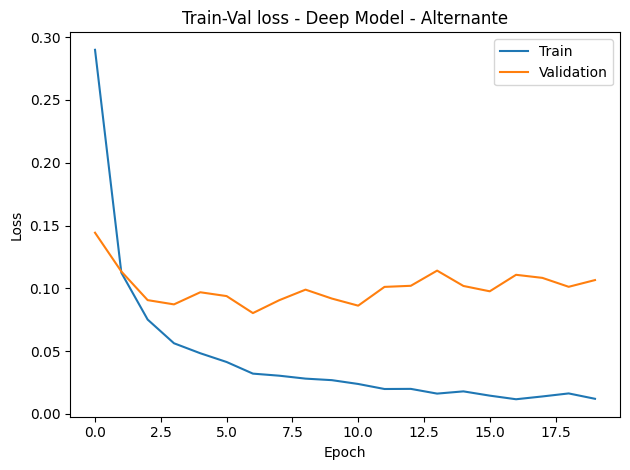

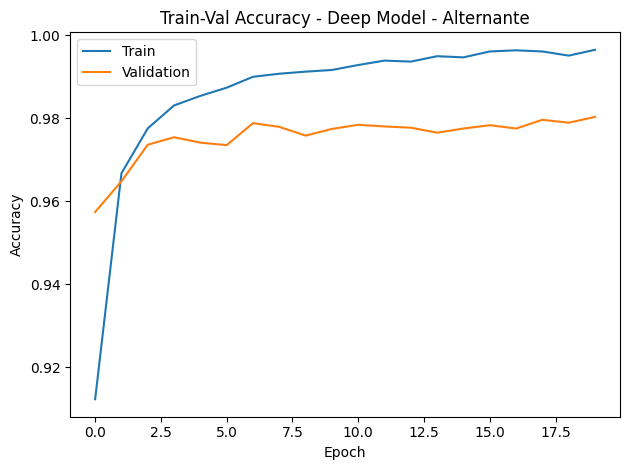

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9754 - loss: 26.3765
Testing loss: 21.890830993652344, Testing Accuracy: 0.978600025177002


In [234]:
# kida random
# Init
m3_c = RNN(784, 10, 200)
m3_c.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_c.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_c.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m3_c.plot_loss("Train-Val loss - Deep Model - Alternante")
m3_c.plot_accuracy("Train-Val Accuracy - Deep Model - Alternante")

# Test
t_loss, t_acc = m3_c.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 4. Funciones de Activacion 1

Epoch 1/20
500/500 - 4s - 8ms/step - accuracy: 0.6761 - loss: 0.9414 - val_accuracy: 0.8857 - val_loss: 0.3854
Epoch 2/20
500/500 - 3s - 5ms/step - accuracy: 0.9137 - loss: 0.3054 - val_accuracy: 0.9402 - val_loss: 0.2106
Epoch 3/20
500/500 - 3s - 5ms/step - accuracy: 0.9450 - loss: 0.1929 - val_accuracy: 0.9579 - val_loss: 0.1495
Epoch 4/20
500/500 - 3s - 6ms/step - accuracy: 0.9572 - loss: 0.1486 - val_accuracy: 0.9546 - val_loss: 0.1654
Epoch 5/20
500/500 - 3s - 5ms/step - accuracy: 0.9640 - loss: 0.1241 - val_accuracy: 0.9669 - val_loss: 0.1172
Epoch 6/20
500/500 - 3s - 5ms/step - accuracy: 0.9714 - loss: 0.0984 - val_accuracy: 0.9684 - val_loss: 0.1188
Epoch 7/20
500/500 - 3s - 5ms/step - accuracy: 0.9760 - loss: 0.0833 - val_accuracy: 0.9668 - val_loss: 0.1136
Epoch 8/20
500/500 - 3s - 5ms/step - accuracy: 0.9789 - loss: 0.0723 - val_accuracy: 0.9681 - val_loss: 0.1177
Epoch 9/20
500/500 - 3s - 5ms/step - accuracy: 0.9825 - loss: 0.0616 - val_accuracy: 0.9719 - val_loss: 0.1070
E

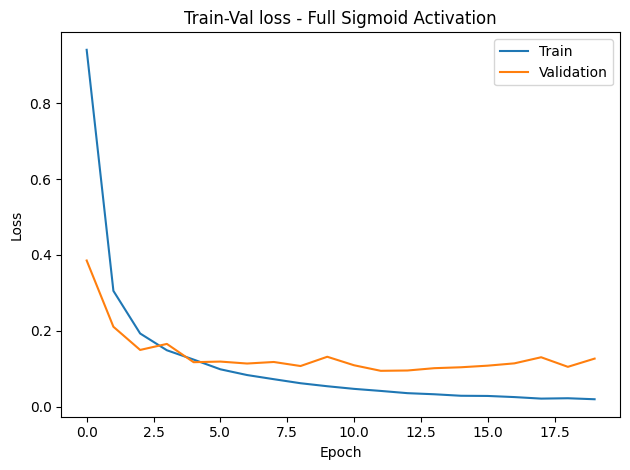

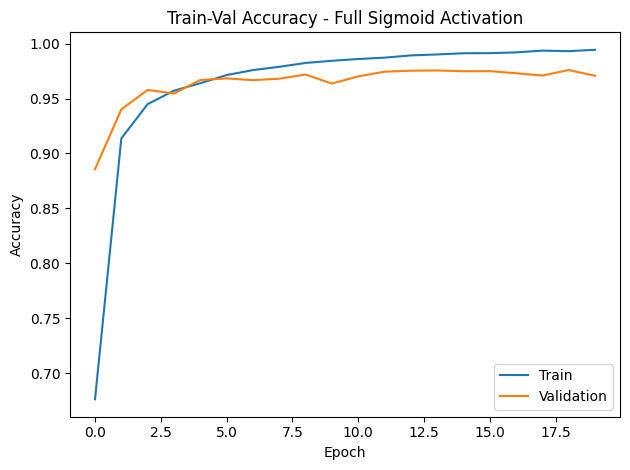

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9492 - loss: 0.2477
Testing loss: 0.21356970071792603, Testing Accuracy: 0.9550999999046326


In [235]:
# Init
m4 = RNN(784, 10, 200)
m4.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m4.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m4.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m4.plot_loss("Train-Val loss - Full Sigmoid Activation")
m4.plot_accuracy("Train-Val Accuracy - Full Sigmoid Activation")

# Test
t_loss, t_acc = m4.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 5. Funciones de Activacion 2

Epoch 1/20
500/500 - 6s - 12ms/step - accuracy: 0.9203 - loss: 0.2593 - val_accuracy: 0.9609 - val_loss: 0.1354
Epoch 2/20
500/500 - 3s - 5ms/step - accuracy: 0.9657 - loss: 0.1119 - val_accuracy: 0.9724 - val_loss: 0.0964
Epoch 3/20
500/500 - 3s - 6ms/step - accuracy: 0.9747 - loss: 0.0808 - val_accuracy: 0.9760 - val_loss: 0.0905
Epoch 4/20
500/500 - 3s - 6ms/step - accuracy: 0.9811 - loss: 0.0619 - val_accuracy: 0.9733 - val_loss: 0.0925
Epoch 5/20
500/500 - 3s - 6ms/step - accuracy: 0.9842 - loss: 0.0510 - val_accuracy: 0.9714 - val_loss: 0.1046
Epoch 6/20
500/500 - 3s - 6ms/step - accuracy: 0.9857 - loss: 0.0449 - val_accuracy: 0.9764 - val_loss: 0.0876
Epoch 7/20
500/500 - 3s - 5ms/step - accuracy: 0.9891 - loss: 0.0352 - val_accuracy: 0.9768 - val_loss: 0.0897
Epoch 8/20
500/500 - 3s - 5ms/step - accuracy: 0.9896 - loss: 0.0338 - val_accuracy: 0.9782 - val_loss: 0.0948
Epoch 9/20
500/500 - 3s - 5ms/step - accuracy: 0.9905 - loss: 0.0305 - val_accuracy: 0.9766 - val_loss: 0.1035


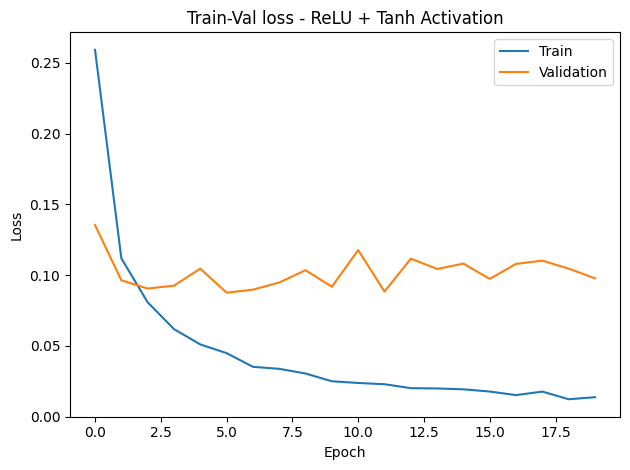

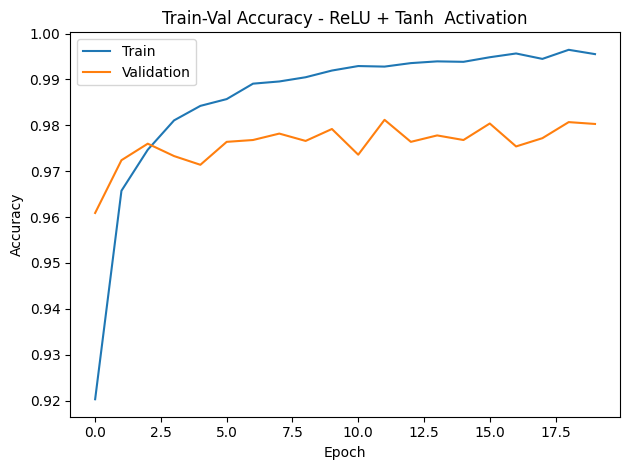

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9748 - loss: 0.1684
Testing loss: 0.15078726410865784, Testing Accuracy: 0.9769999980926514


In [236]:
# Init
m5 = RNN(784, 10, 200)
m5.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='tanh'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m5.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m5.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m5.plot_loss("Train-Val loss - ReLU + Tanh Activation")
m5.plot_accuracy("Train-Val Accuracy - ReLU + Tanh  Activation")

# Test
t_loss, t_acc = m5.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 6. Tamaño Batch Grande

In [237]:
# iterar por cada una de las topologias
performance_2 = [] # almacenamiento de resultados

for batch_size in [100, 500, 1000, 5000, 10000]:
    # Realizar otra vez el shuffle
    datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
    datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
    datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

    datos_entreno_bigbatch = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(batch_size)
    datos_validacion_bigbatch = datos_validacion.batch(batch_size)
    datos_prueba_bigbatch = datos_prueba.batch(batch_size)

    # Inicializar RNN
    m6 = RNN(784, 10, 256)
    m6.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='tanh'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
    # Compilar otpimizador
    m6.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Metricas de etrenamiento
    (e_loss, e_acc, _, _, t_time) = m6.train(datos_entreno_bigbatch, datos_validacion_bigbatch, num_epochs=20)
    # Metricas de prueba
    t_loss, t_acc = m6.test(datos_prueba_bigbatch)
    performance_2.append({"batch_size": batch_size, "e_loss": e_loss, "e_acc": e_acc, "t_loss": t_loss, "t_acc": t_acc, "training_time": t_time})
    print(f"finished for bartch size {batch_size}")
    if(batch_size==10000):
        training_times.append(t_time)  # Guardar tiempo
        test_losses.append(t_loss)     # Guardar pérdida
        test_accuracies.append(t_acc)  # Guardar accuracy


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.1626
finished for bartch size 100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9740 - loss: 0.2277
finished for bartch size 500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9645 - loss: 0.3551
finished for bartch size 1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9344 - loss: 0.3379 
finished for bartch size 5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9546 - loss: 0.1781
finished for bartch size 10000


In [238]:
df6 = pd.DataFrame(performance_2)
df6

,batch_size,e_loss,e_acc,t_loss,t_acc,training_time
0,100,0.014050,0.99608,0.133017,0.9788,55.851380
1,500,0.009032,0.99710,0.197328,0.9772,27.498610
2,1000,0.004463,0.99872,0.310692,0.9676,18.063159
3,5000,0.023695,0.99346,0.299265,0.9407,14.305485
4,10000,0.073834,0.97786,0.178100,0.9546,14.982460


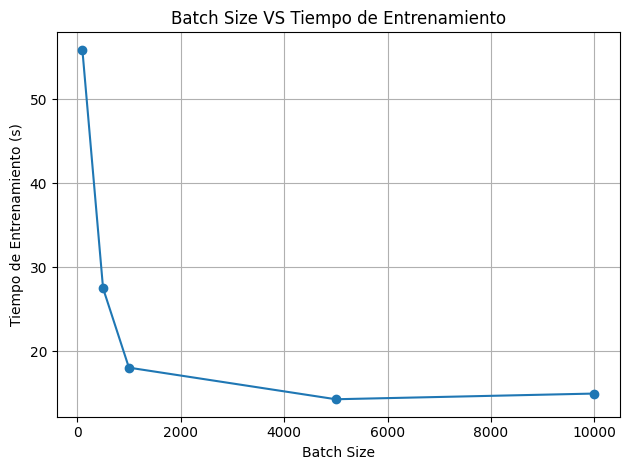

In [239]:
plt.plot(df6["batch_size"], df6["training_time"],'-o')
plt.xlabel("Batch Size")
plt.ylabel("Tiempo de Entrenamiento (s)")
plt.title("Batch Size VS Tiempo de Entrenamiento")
plt.grid()
plt.tight_layout()
plt.show()

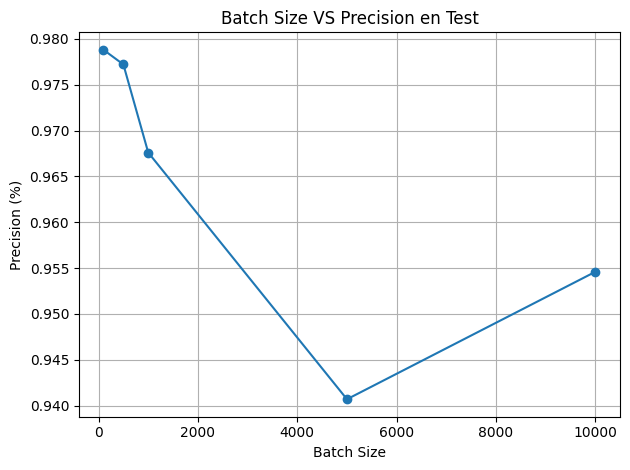

In [240]:
plt.plot(df6["batch_size"], df6["t_acc"],'-o')
plt.xlabel("Batch Size")
plt.ylabel("Precision (%)")
plt.title("Batch Size VS Precision en Test")
plt.grid()
plt.tight_layout()
plt.show()


## 7. Descenso de Gradiente Estocástico (SGD)

Para esta actividad se ajusta el tamaño de batch a 1, lo que implica entrenamiento con descenso de gradiente estocástico puro. Esto permite observar cómo cambia la estabilidad y el tiempo de ejecución del modelo.

**Objetivo**:
- Comparar tiempo de ejecución y precisión con configuraciones anteriores.
- Evaluar estabilidad del entrenamiento.
- Analizar si los resultados son coherentes con la teoría.


In [241]:
# Realizar otra vez el shuffle
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

datos_entreno_smallbatch = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(batch_size)
datos_validacion_smallbatch = datos_validacion.batch(1)
datos_prueba_smallbatch = datos_prueba.batch(1)

# Inicializar RNN
m7 = RNN(784, 10, 200)
# Metricas de etrenamiento
(e_loss, e_acc, _, _, t_time) = m7.train(datos_entreno_smallbatch, datos_validacion_smallbatch, num_epochs=20)
training_times.append(t_time)  # Guardar tiempo
# Metricas de prueba
t_loss, t_acc = m7.test(datos_prueba_smallbatch)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
# Imprimir resultados
print(f"Training Time: {t_time}")
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

C:\Users\50250\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9262 - loss: 31.9656
Training Time: 266.0723066329956
Testing loss: 28.307043075561523, Testing Accuracy: 0.9361000061035156


In [242]:
print(training_times)
print(test_losses)
print(test_accuracies)

[37.57843065261841, 55.08442044258118, 56.72417402267456, 67.1392114162445, 105.98244333267212, 52.27785110473633, 56.2156138420105, 57.5851411819458, 14.982460498809814, 266.0723066329956]
[17.654598236083984, 17.10752296447754, 24.912071228027344, 20.707935333251953, 26.191280364990234, 21.890830993652344, 0.21356970071792603, 0.15078726410865784, 0.17809955775737762, 28.307043075561523]
[0.9807000160217285, 0.9803000092506409, 0.9793000221252441, 0.9797000288963318, 0.9767000079154968, 0.978600025177002, 0.9550999999046326, 0.9769999980926514, 0.9545999765396118, 0.9361000061035156]


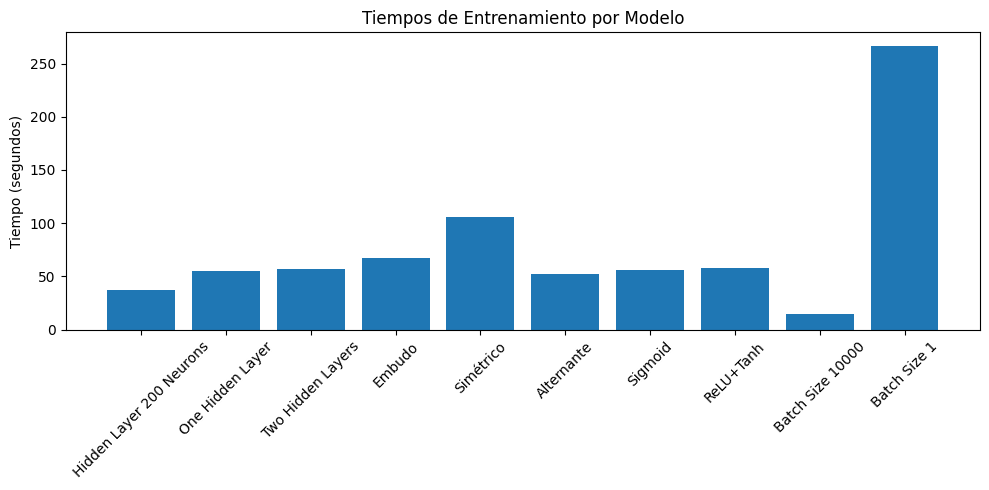

In [243]:
model_names = [
    "Hidden Layer 200 Neurons","One Hidden Layer", "Two Hidden Layers", "Embudo", "Simétrico",
    "Alternante", "Sigmoid", "ReLU+Tanh", "Batch Size 10000", "Batch Size 1"
]

# Crear DataFrame para la tabla comparativa
df_summary = pd.DataFrame({
    "Modelo": model_names,
    "Tiempo de Entrenamiento (s)": training_times,
    "Pérdida en Prueba": test_losses,
    "Precisión en Prueba": test_accuracies
})

# Graficar tiempos de entrenamiento
plt.figure(figsize=(10, 5))
plt.bar(model_names, training_times)
plt.title("Tiempos de Entrenamiento por Modelo")
plt.ylabel("Tiempo (segundos)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## 8. Tasa de aprendizaje baja


Training Time (Low LR): 39.41949534416199


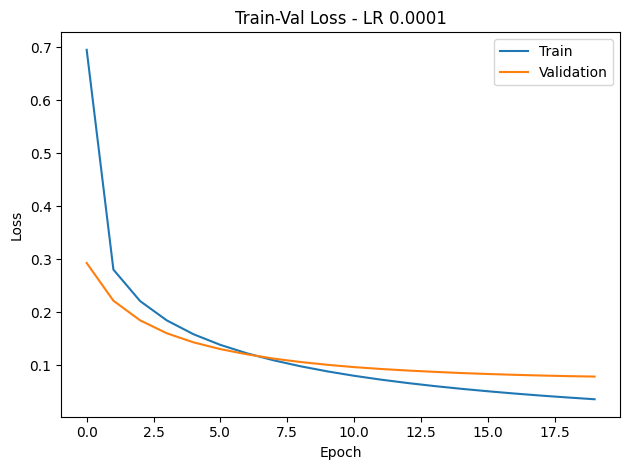

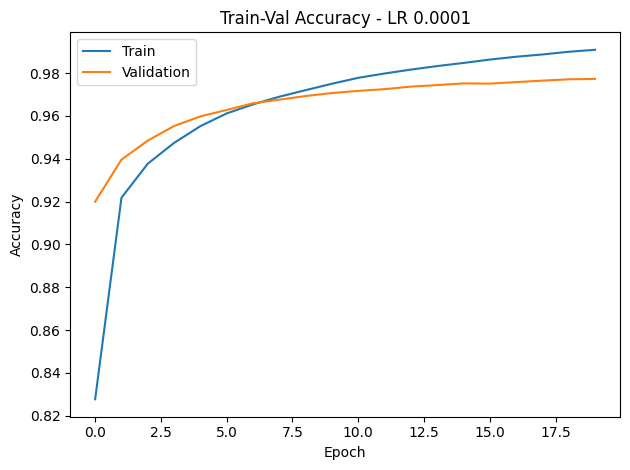

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9734 - loss: 14.0548
Testing loss: 12.557805061340332, Testing Accuracy: 0.9767000079154968


In [244]:

BATCH_SIZE = 100
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno)).batch(BATCH_SIZE)
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion)).batch(BATCH_SIZE)
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba)).batch(BATCH_SIZE)

# Crear y compilar modelo con tasa de aprendizaje baja
m8 = RNN(784, 10, 200)
m8.model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
m8.model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento
(e_loss, e_acc, _, _, t_time) = m8.train(datos_entreno, datos_validacion, num_epochs=20)
training_times.append(t_time)  # Guardar tiempo
print(f"Training Time (Low LR): {t_time}")
m8.plot_loss("Train-Val Loss - LR 0.0001")
m8.plot_accuracy("Train-Val Accuracy - LR 0.0001")

# Prueba
t_loss, t_acc = m8.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracya
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")



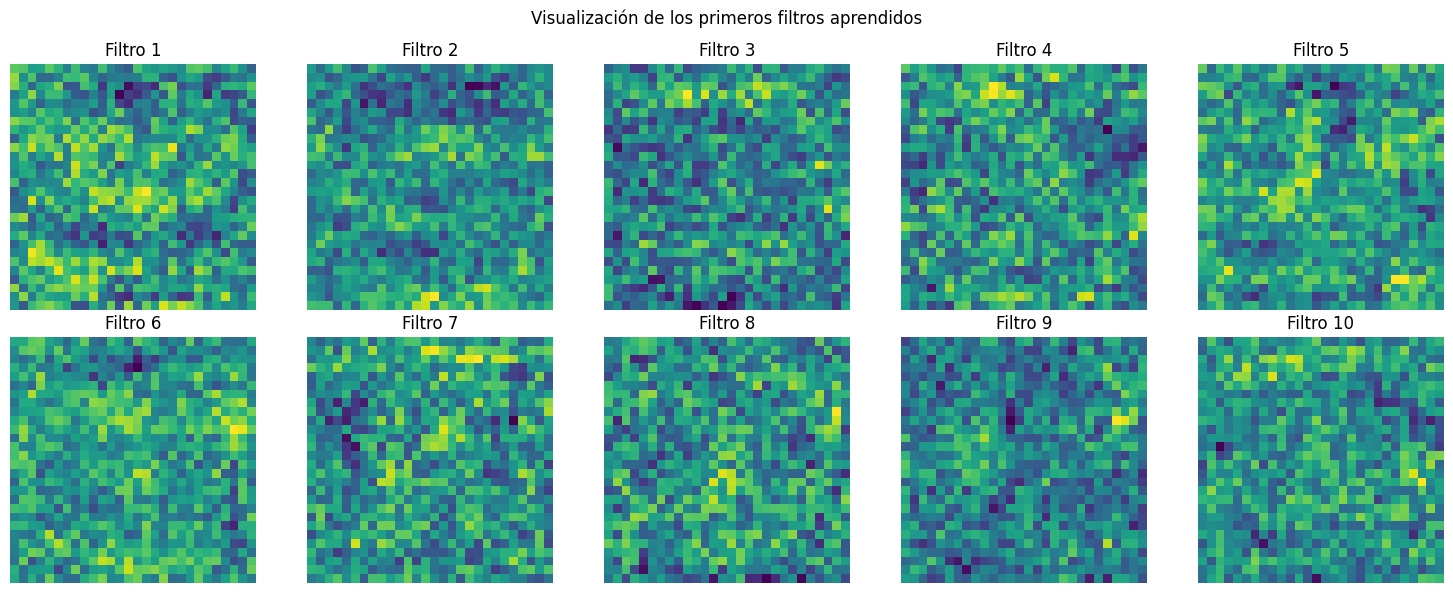

In [245]:
# Extraer pesos de la primera capa (Flatten no cuenta, usamos la primera Dense)
pesos, biases = m8.model.layers[1].get_weights()

# Visualizar los primeros 10 filtros (pesos) como imágenes de 28x28
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axs[i // 5, i % 5]
    img = pesos[:, i].reshape(28, 28)
    ax.imshow(img, cmap='viridis')
    ax.set_title(f"Filtro {i+1}")
    ax.axis('off')
plt.suptitle("Visualización de los primeros filtros aprendidos")
plt.tight_layout()
plt.show()


## 9.Tasa de Aprendizaje Alta 

Training Time (High LR): 37.90733194351196


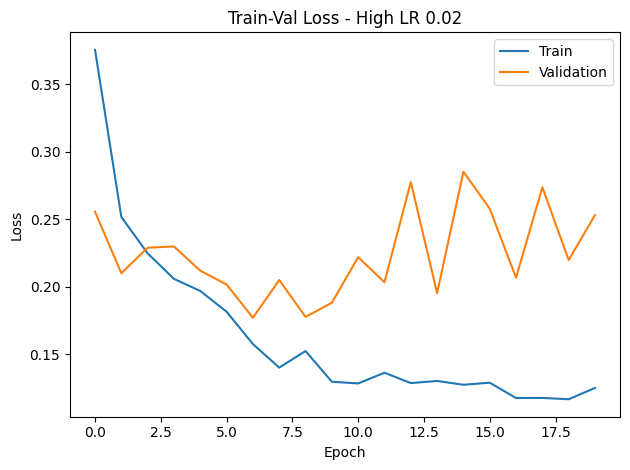

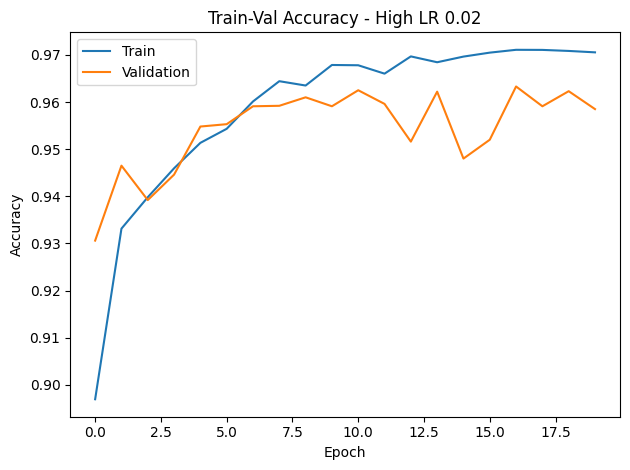

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9478 - loss: 78.3459
Testing loss: 63.19511795043945, Testing Accuracy: 0.954800009727478


In [246]:
# Crear y compilar modelo con tasa de aprendizaje alta
m9 = RNN(784, 10, 200)
m9.model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
m9.model.compile(
    optimizer=Adam(learning_rate=0.02),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento
(e_loss, e_acc, _, _, t_time) = m9.train(datos_entreno, datos_validacion, num_epochs=20)
training_times.append(t_time)  # Guardar tiempo
print(f"Training Time (High LR): {t_time}")
m9.plot_loss("Train-Val Loss - High LR 0.02")
m9.plot_accuracy("Train-Val Accuracy - High LR 0.02")

# Prueba
t_loss, t_acc = m9.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracya
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

## 10. Optimización

Training Time (Advanced Opt): 46.277252197265625


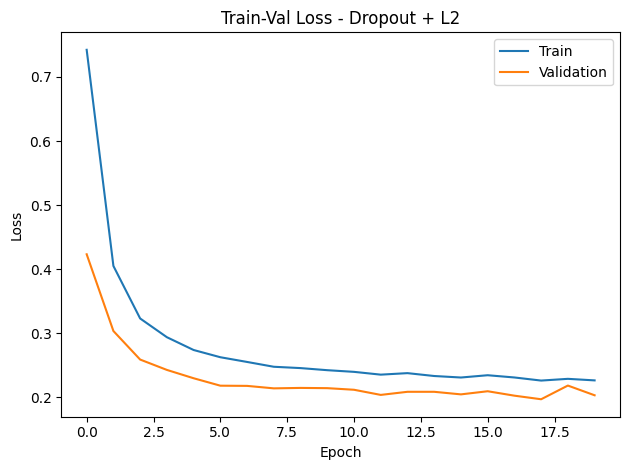

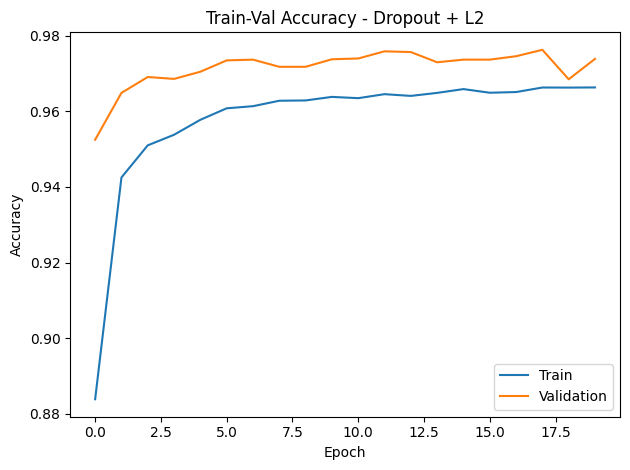

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9271 - loss: 24.1943
Testing loss: 19.54841423034668, Testing Accuracy: 0.9395999908447266


In [247]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

m10 = RNN(784, 10, 200)
m10.model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])
m10.model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento
(e_loss, e_acc, v_loss, v_acc, t_time) = m10.train(datos_entreno, datos_validacion, num_epochs=20)
training_times.append(t_time)  # Guardar tiempo
print(f"Training Time (Advanced Opt): {t_time}")
m10.plot_loss("Train-Val Loss - Dropout + L2")
m10.plot_accuracy("Train-Val Accuracy - Dropout + L2")

# Prueba
t_loss, t_acc = m10.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracya
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")


# 10.Visualización

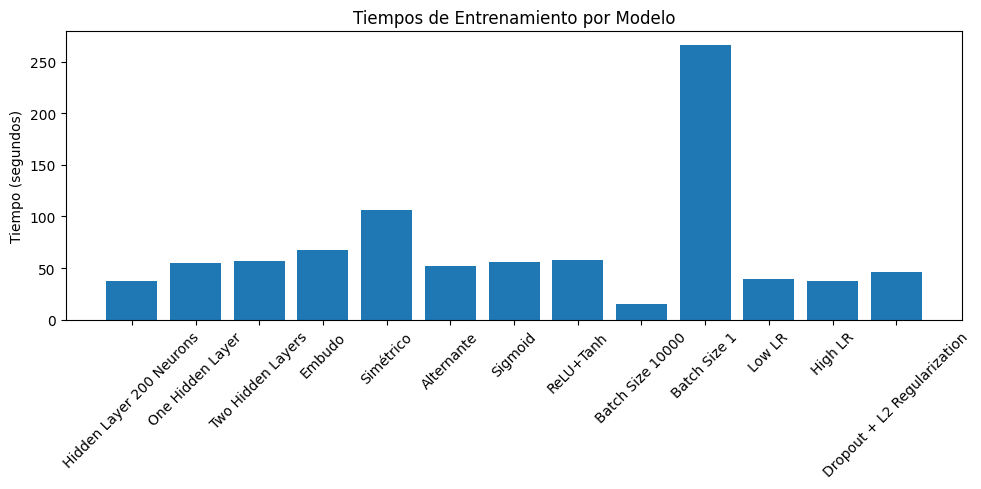

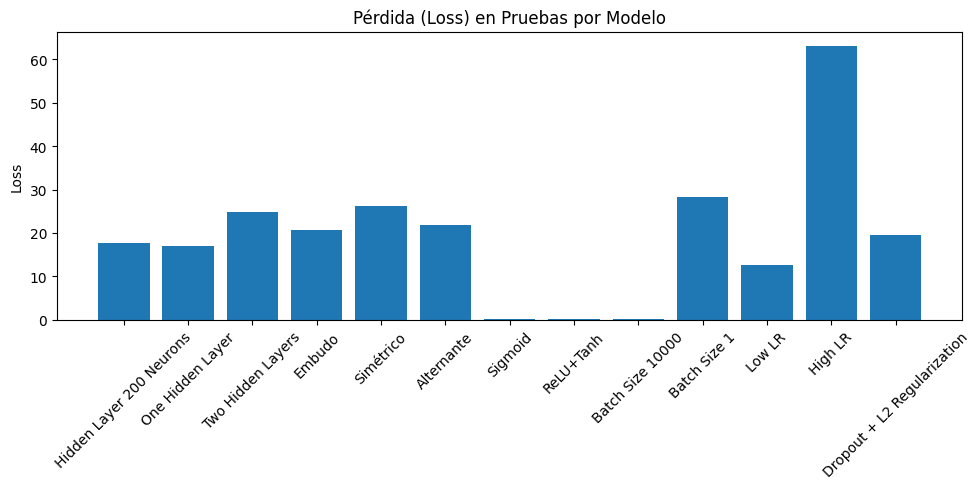

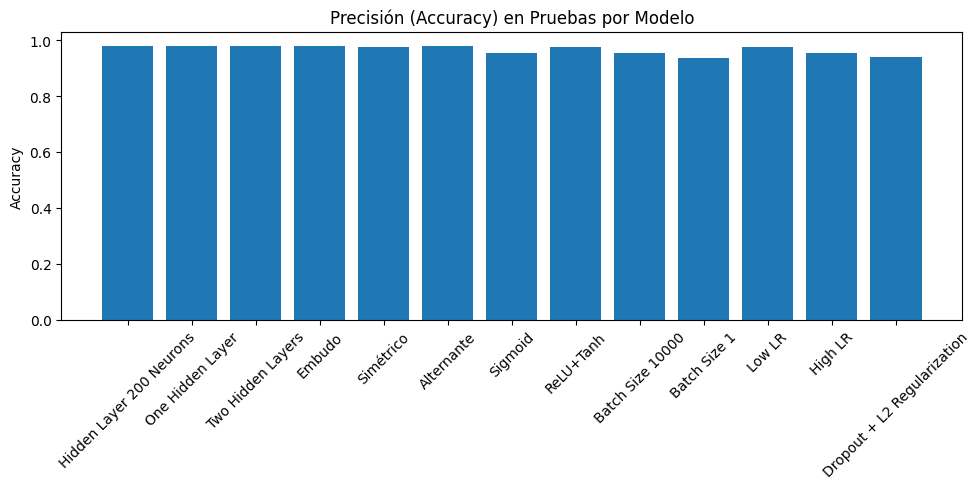

In [248]:
model_names = [
    "Hidden Layer 200 Neurons","One Hidden Layer", "Two Hidden Layers", "Embudo", "Simétrico",
    "Alternante", "Sigmoid", "ReLU+Tanh", "Batch Size 10000", "Batch Size 1", "Low LR", "High LR", "Dropout + L2 Regularization"
]

# Crear DataFrame para la tabla comparativa
df_summary = pd.DataFrame({
    "Modelo": model_names,
    "Tiempo de Entrenamiento (s)": training_times,
    "Pérdida en Prueba": test_losses,
    "Precisión en Prueba": test_accuracies
})

# Graficar tiempos de entrenamiento
plt.figure(figsize=(10, 5))
plt.bar(model_names, training_times)
plt.title("Tiempos de Entrenamiento por Modelo")
plt.ylabel("Tiempo (segundos)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Graficar pérdidas
plt.figure(figsize=(10, 5))
plt.bar(model_names, test_losses)
plt.title("Pérdida (Loss) en Pruebas por Modelo")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Graficar exactitud
plt.figure(figsize=(10, 5))
plt.bar(model_names, test_accuracies)
plt.title("Precisión (Accuracy) en Pruebas por Modelo")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## 11. Modelo Optimo

Epoch 1/20
98/98 - 3s - 26ms/step - accuracy: 0.8836 - loss: 0.3794 - val_accuracy: 0.8824 - val_loss: 0.6175
Epoch 2/20
98/98 - 1s - 12ms/step - accuracy: 0.9541 - loss: 0.1523 - val_accuracy: 0.9384 - val_loss: 0.2789
Epoch 3/20
98/98 - 1s - 13ms/step - accuracy: 0.9676 - loss: 0.1074 - val_accuracy: 0.9666 - val_loss: 0.1357
Epoch 4/20
98/98 - 1s - 12ms/step - accuracy: 0.9737 - loss: 0.0841 - val_accuracy: 0.9723 - val_loss: 0.0971
Epoch 5/20
98/98 - 1s - 12ms/step - accuracy: 0.9789 - loss: 0.0683 - val_accuracy: 0.9771 - val_loss: 0.0761
Epoch 6/20
98/98 - 1s - 14ms/step - accuracy: 0.9827 - loss: 0.0546 - val_accuracy: 0.9786 - val_loss: 0.0690
Epoch 7/20
98/98 - 1s - 13ms/step - accuracy: 0.9849 - loss: 0.0471 - val_accuracy: 0.9788 - val_loss: 0.0708
Epoch 8/20
98/98 - 1s - 12ms/step - accuracy: 0.9865 - loss: 0.0412 - val_accuracy: 0.9789 - val_loss: 0.0698
Epoch 9/20
98/98 - 1s - 13ms/step - accuracy: 0.9869 - loss: 0.0384 - val_accuracy: 0.9782 - val_loss: 0.0736
Epoch 10/2

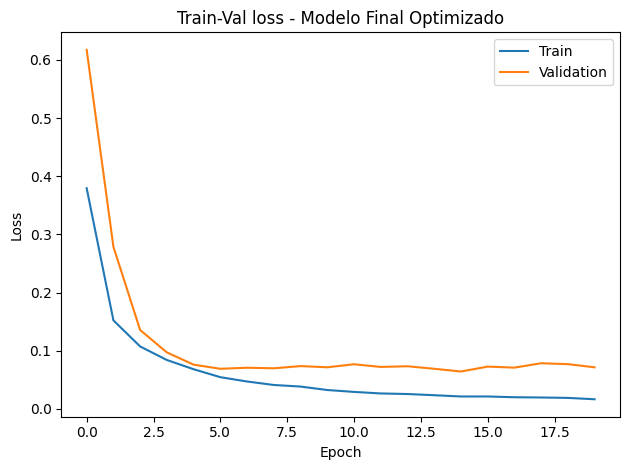

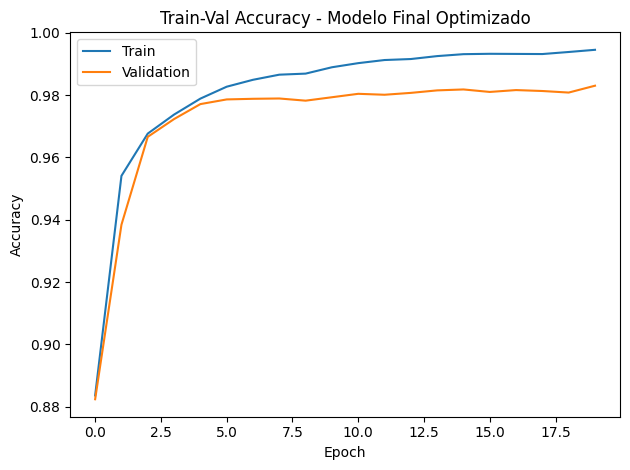

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9088 - loss: 61.4452
Testing loss: 53.8761, Testing Accuracy: 0.9182


In [282]:
BATCH_SIZE = 512  # más grande = menos pasos por época
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno)).batch(BATCH_SIZE)
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion)).batch(BATCH_SIZE)
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba)).batch(BATCH_SIZE)

best_model = RNN(784, 10, 200)
best_model.model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # estabiliza entrenamiento
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(10, activation='softmax')
])

best_model.model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

(e_loss, e_acc, _, _, t_time) = best_model.train(
    datos_entreno,
    datos_validacion,
    num_epochs=20,
    verbose=2
)

print(f"Training Time: {t_time:.4f} segundos")

# Curvas
best_model.plot_loss("Train-Val loss - Modelo Final Optimizado")
best_model.plot_accuracy("Train-Val Accuracy - Modelo Final Optimizado")

# Evaluación
t_loss, t_acc = best_model.test(datos_prueba)
print(f"Testing loss: {t_loss:.4f}, Testing Accuracy: {t_acc:.4f}")

